<div class="alert alert-success">
    <h3 align="center">Programming Exercise 2: Logistic Regression</h3>
</div>

From the machine learning course presented at Stanford by Andrew Ng.

In this assignment you only need to implement the following functions:
- `sigmoid(x)`: 
 - this is a warmup exercize and not graded.
- `logistic_regression_cost(theta, X, y)`: 
 - cost function for logistic regression without regularization.
- `grads(theta, X, y)`: 
 - the gradients of the above function.
- `predict(theta, X):`: 
 - prediction function which predicts the label or class of the input data.
- `regularized_logistic_regression_cost(theta, X, y, reg)`: 
 - cost function for logistic regression with regularization.
- `regularized_grads(theta, X, y, reg)`: 
 - the gradients of the above function.
    

## Logistic Regression

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
#sns.set()

from utils import *

from sklearn import linear_model

# setup for printing numpy arrays
np.set_printoptions(precision=2)

In [2]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

## Part 1: Logistic Regression

In the first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university.

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision. 

### Data

The data that you need for this part of the assignment is given to you in the text file `data/ex2data1.txt`. Here, you can see the first 10 rows from this file. The first two columns or the **input features** are the applicant's scores on two different exams and the third column (or the **target output**) is the admissions decesion. Here, `0` means "Not Admitted" and `1` means "Admitted". 

```python
34.62365962451697,78.02469281536240,0
30.28671076822607,43.89499752400101,0
35.84740876993872,72.90219802708364,0
60.18259938620976,86.30855209546826,1
79.03273605071010,75.34437643691030,1
45.08327747668339,56.31637178153050,0
61.10666453684766,96.51142588489624,1
75.02474556738889,46.55401354116538,1
76.09878670226257,87.42056971926803,1
84.43281996120035,43.53339331072109,1
```

Now, our goal is to build a classification model that estimates the probability of admission based on the exam scores.

### Loading data

In [3]:
X, y = load_data(fname='data/ex2data1.txt', include_bias=True)

print(X.shape)
print(y.shape)

(100, 3)
(100,)


In [4]:
x_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)
merged_df = x_df.merge(y_df,how='inner', left_index=True,right_index=True)
merged_df.columns = ['ones', 'exam_score_1', 'exam_score_2', 'label']
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ones,100.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
exam_score_1,100.0,65.644274,19.458222,30.058822,50.919511,67.032988,80.212529,99.827858
exam_score_2,100.0,66.221998,18.582783,30.603263,48.179205,67.682381,79.360605,98.869436
label,100.0,0.600000,0.492366,0.000000,0.000000,1.000000,1.000000,1.000000


### Visualizing data

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (`profit` and `population`). (Many other problems that you will encounter in real life are multi-dimensional and can’t be plotted on a 2-d plot.) 

Now, you can call `plot_data` to create a scatter plot of the data. Again, we have implemented this function for you and imported it at the begining of this notebook. Run the following cell to see the data.

Text(0.5, 1.0, 'Training data')

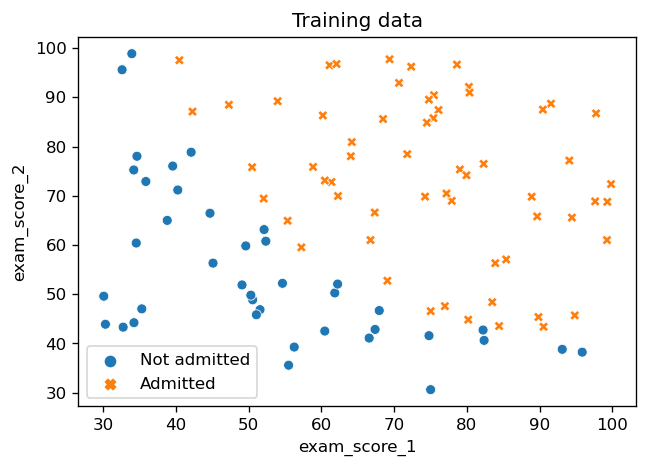

In [5]:
ax = sns.scatterplot(x='exam_score_1', y='exam_score_2', hue='label', data=merged_df, style = 'label')
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['Not admitted', 'Admitted'])
plt.title('Training data')
# or just plot_data(X, y, labels=['Not Admitted', 'Admitted'])

### Sigmoid function 

Before you start with the actual cost function, recall that the logistic regression hypothesis is deﬁned as:
$$h_\theta(x)=g(\theta^T x)$$

where function g is the sigmoid function. The sigmoid function is deﬁned as:
$$g(z)=\frac{1}{1 + e^{-z}}$$

Your first step is to implement this function so it can be called by the rest of your program. When you are finished, try testing a few values by calling `sigmoid(x)`. For large positive values of `x`, the sigmoid should be close to `1`, while for large negative values, the sigmoid should be close to `0`. Evaluating `sigmoid(0)` should give you exactly `0.5`. 

Note that your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element.

In [6]:
def sigmoid(z): #could also just use: expit(z)
    """ Sigmoid function.
    Parameters:
        - x: input, can be a scaler value or a numpy array
    Returns:
        - The sogmoid of x. 
    Examples:
        - sigmoid(0)    -> 0.5
        - sigmoid(100)  -> 1.0
        - sigmoid(-100) -> 0.0
    """
    return 1.0 / (1.0 + np.exp(-z))

In [7]:
def hypothesis(X, theta):
    return sigmoid(np.dot(X, theta)) #  sigmoid(X.dot(theta))

Now, you can run the following cells to see if your implementation of sigmoid function is correct.

In [8]:
# testing sigmoid for scaler values
print("sigmoid(0) = %.2f" % sigmoid(0))
print("sigmoid(100) = %.2f" % sigmoid(100))
print("sigmoid(-100) = %.2f" % sigmoid(-100))

sigmoid(0) = 0.50
sigmoid(100) = 1.00
sigmoid(-100) = 0.00


Let's do a quick sanity check to make sure the implementation of sigmoid function is correct.

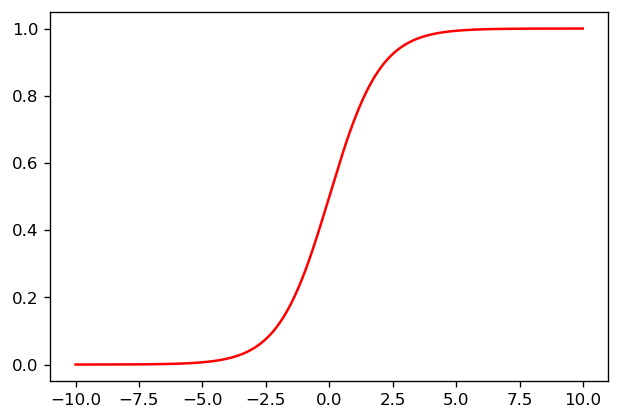

In [9]:
x = np.arange(-10, 10, 0.01)
plt.plot(x, sigmoid(x), 'r')
plt.show()

### Cost function and gradient

Now you will implement the cost function and gradient for logistic regression. Complete the code in `logistic_regression_cost()` to return the cost and the `grads()` to return the gradient of the cost function.

Recall that the cost function in logistic regression is

$$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [-y^{(i)} \log(h_\theta(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)}))]$$

Vectorized implementation:

$h = g(X\theta)$

$J(\theta) = \frac{1}{m}(-y^T log(h)-(1-y)^Tlog(1-h))$


The gradient of the cost is a vector of the same length as $\theta$ where $j^{th}$ element (for $j=0,1,...,n$) is defined as follows:

$$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m ((h_\theta(x^i) - y^i) \cdot x_j^i)$$

Vectorized:
$\nabla J(\theta) = \frac{1}{m} \cdot X^T \cdot (g(X\theta)-y)$

Note that while this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $h_\theta(x)$.

In [10]:
def logistic_regression_cost(theta, X, y):
    """ Vectorized implementation of logistic regression cost function.
    Parameters:
        - theta: Parameters, a 1d array of shape (n + 1,)
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 1d array of shape (m,)
    Returns:
        - logistic regression cost
    """
    theta = theta[:, np.newaxis] #trick to make numpy minimize work
    m = y.shape[0]
    h = hypothesis(X,theta) # sigmoid(X.dot(theta))
    cost = (1/m)*(-y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h)))
    return cost

def grads(theta, X, y):
    """ Vectorized implementation of the gradient of logistic regression cost function.
    Parameters:
        - theta: Parameters, a 1d array of shape (n + 1,)
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m,)
    Returns:
        - gradient of the logistic regression cost function, a 2d array of shape (n + 1,)
    """
    m = y.size #or y.shape[0]
    return 1/m * (np.dot(X.T,(hypothesis(X,theta) - y)))

To check your implementation of cost function, run the following cell. If you have implemented the cost function correctly, you should see that the cost is about `0.693` and gradient vector is about `[-0.1, -12.01, -11.26]`.

In [11]:
# testing cost function and gradient
theta_initial = np.zeros(shape=(X.shape[1]))
print("cost = %.3f" % logistic_regression_cost(theta_initial, X, y))
print("gradient = %s" % grads(theta_initial, X, y)) #.ravel())

cost = 0.693
gradient = [ -0.1  -12.01 -11.26]


In [12]:
theta_test = np.array([-24, 0.2, 0.2])
print("cost = %.3f" % logistic_regression_cost(theta_test, X, y))
print("gradient = %s" % grads(theta_test, X, y)) #.ravel())
#correct numbers:
#cost = 0.218
#gradient = [0.04 2.57 2.65]

cost = 0.218
gradient = [0.04 2.57 2.65]


### Learning parameters using an optimization solver `scipy.optimize.minimize`

"Conjugate gradient", "BFGS", and "L-BFGS" are more sophisticated, faster ways to optimize $\theta$ that can be used instead of gradient descent. 

In [13]:
from scipy.optimize import minimize

The `scipy.optimize.minimize` is an optimization solver that finds the minimum of a function. For logistic regression, you want to optimize the cost function `J(θ)` with parameters `θ`.

You are going to use `minimize` to find the best parameters `θ` for the logistic regression cost function, given a fixed dataset (of `X` and `y` values). You will pass to `minimize` the following inputs:
- **Initial values**: The initial values of the parameters we are trying to optimize.
- **Cost function**: A function that, when given the training set and a particular `θ`, computes the logistic regression cost for the dataset (`X`, `y`).
- **Gradients**: A function, when given the training set and a particular `θ`, computes gradient with respect to `θ` for the dataset (`X`, `y`).


```python
minimize(cost_function, x0=theta0, args=(X, y), method='CG', jac=grads)
```

In [14]:
result = minimize(logistic_regression_cost, x0=np.zeros((3,)), args=(X, y), method='bfgs', jac=grads)

/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/3196239211.py:13: RuntimeWarning: divide by zero encountered in log
  cost = (1/m)*(-y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h)))


In [15]:
theta_opt = result.x  # optimal theta
print(theta_opt)
#expected numbers:
#[-25.161, 0.206, 0.201']

[-25.16   0.21   0.2 ]


Now, we will call your cost function using the optimal parameters of θ. You should see that the cost is about `0.203`. 

In [16]:
cost = logistic_regression_cost(theta_opt, X, y)
print("cost = %.5f" % logistic_regression_cost(theta_opt, X, y))

cost = 0.20350


This final `θ` value will then be used to plot the decision boundary on the training data, resulting in a figure similar to Figure 2. We also encourage you to look at the code in `plot_decision_boundary()` to see how to plot such a boundary using the `θ` values. This function is implemented in the file `utils.py`.

If everything is ok, you should see something like the following:

<img src='imgs/part_1_log_reg_decision_boundary.png' width='50%'>

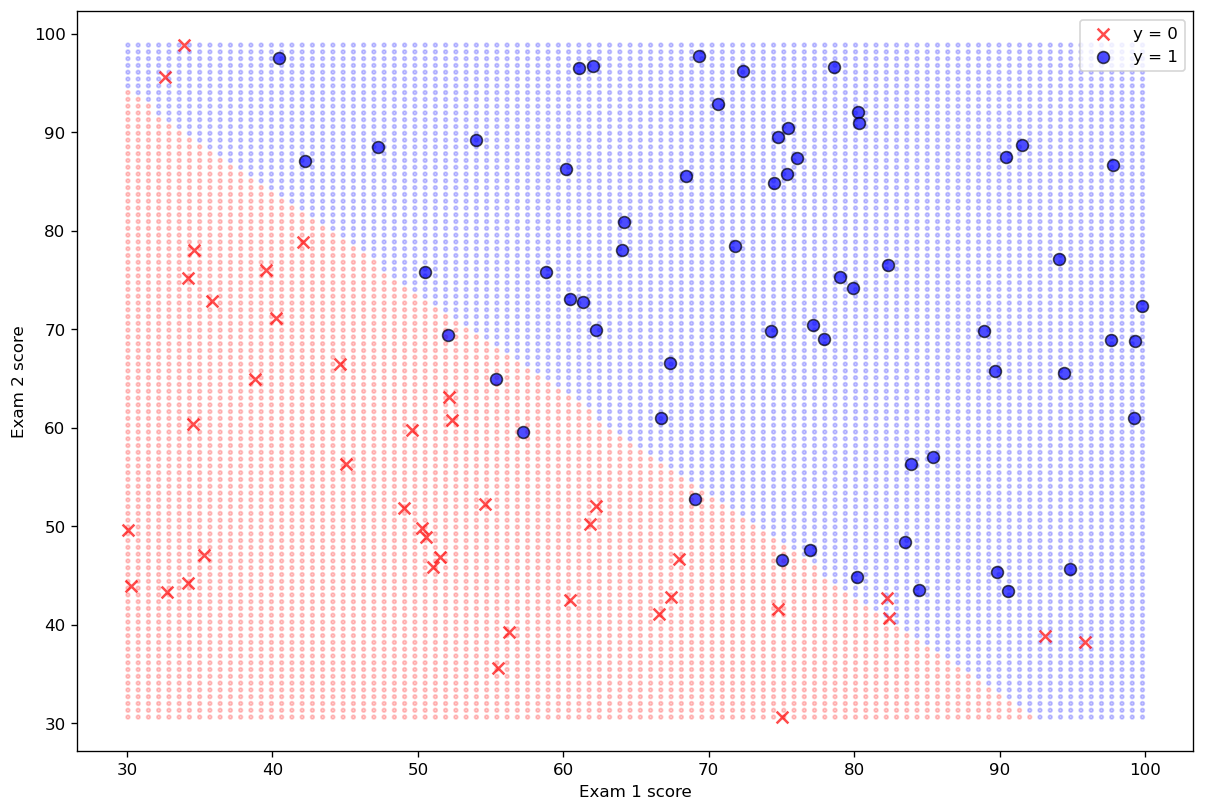

In [17]:
plot_decision_boundary(theta_opt, X, y)

### Evaluating the classifier

After learning the parameters, you can use the model to predict whether a particular student will be admitted. For a student with an Exam 1 score of `45` and an Exam 2 score of `85`, you should expect to see an admission probability of `0.776`. 

Another way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set. In this part, your task is to complete the code in `predict()`. The predict function will produce `1` or `0` predictions given a dataset and a learned parameter vector `θ`. 

In [18]:
def predict(theta, X):
    return np.where(hypothesis(X,theta) >= 0.5, 1, 0)   

In [19]:
x_test = np.array([[1, 45, 85]])
print(sigmoid(x_test @ theta_opt.T))
print(predict(theta_opt, x_test))
#correct numbers:
#[0.78]
#[1]    

[0.78]
[1]


#### Accuracy on the training set

In [20]:
y_pred_prob = predict(theta_opt,X)

In [21]:
f'Train accuracy: {np.mean(y_pred_prob == merged_df.label.values) * 100}' #y

'Train accuracy: 89.0'

#### Equivalent code using Scikit-Learn:

In [22]:
log_reg = linear_model.LogisticRegression(solver='newton-cg', max_iter=400)
log_reg.fit(merged_df[['exam_score_1', 'exam_score_2']].values,
            merged_df.label.values)

LogisticRegression(max_iter=400, solver='newton-cg')

In [23]:
log_reg.intercept_, log_reg.coef_
#coeffs and intercept of theta_opt

(array([-25.05]), array([[0.21, 0.2 ]]))

#### Sklearn logistic regression accuracy:

In [24]:
log_reg.score(merged_df[['exam_score_1', 'exam_score_2']].values,
              merged_df.label.values)  #y instead of merged_df.label.values

0.89

## Part 2: Regularized Logistic Regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. 

Suppose you are the product manager of the factory and you have the test results for some microchips on two diﬀerent tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

### Visualizing data

Similar to the previous part of this exercise, `plot_data()` is used to generate a figure like Figure 3, where the axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers.


In [25]:
X2, y2 = load_data(fname='data/ex2data2.txt')
print(X2.shape)
print(y2.shape)

(118, 3)
(118,)


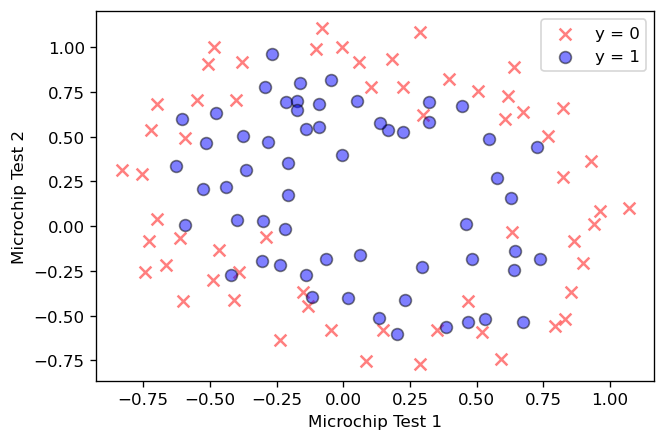

In [26]:
plot_data(X2, y2, xlabel='Microchip Test 1', ylabel='Microchip Test 2')

### Feature Mapping

One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of x1and x2 up to some power. As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.


There is no linear decision boundary that will perform well on this data. One way to deal with this using a linear technique like logistic regression is to construct features that are derived from polynomials of the original features. Let's start by creating a bunch of polynomial features using the `map_features()` function that we have implented for you in `utils.py`.

In [27]:
degree = 8
X_poly = map_features(X2[:, 1], X2[:, 2], degree=degree)
print(X_poly.shape)

(118, 45)


Now we need to modify the cost and gradient functions from part 1 to include the regularization term. Please complete the implementation of the two following function.

In [28]:
def regularized_logistic_regression_cost(theta, X, y, reg):
    """ Vectorized implementation of logistic regression cost function.
    Parameters:
        - theta: Parameters, a 1d array of shape (n + 1,)
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 1d array of shape (m,)
        - reg: the regularization parameter
    Returns:
        - logistic regression cost
    """
    m = y.size
    return logistic_regression_cost(theta, X, y) + reg/(2.0*m) * np.dot(theta[1:],theta[1:])

def regularized_grads(theta, X, y, reg):
    """ Vectorized implementation of the gradient of logistic regression cost function.
    Parameters:
        - theta: Parameters, a 1d array of shape (n + 1,)
        - X: Inputs, a 2d array of shape (m, n + 1)
        - y: Target values, a 2d array of shape (m,)
        - reg: the regularization parameter
    Returns:
        - gradient of the logistic regression cost function, a 2d array of shape (n + 1,)
    """
    #raise NotImplementedError("You need to implement `regularized_grads` function.")
    m = y.size
    return grads(theta, X, y) + reg/(2.0*m) * np.concatenate(([0], theta[1:])).T

##### testing

If you have implented these two function correctly, you should see that for $\theta$ equals to zero, the cost is about `0.693`.

In [29]:
theta_initial_xpoly = np.zeros(X_poly.shape[1])
cost = regularized_logistic_regression_cost(theta_initial_xpoly, X_poly, y2, 1.0)
print("cost = %.3f"% cost)

cost = 0.693


In [30]:
lambda_reg1 = 1
cost_reg1 = regularized_logistic_regression_cost(theta_initial_xpoly, X_poly, y2, lambda_reg1)
print('Cost at initial theta (zeros):\n',cost_reg1)
print('Gradient at initial theta (zeros) - top 5:')
grad_reg1 = regularized_grads(theta_initial_xpoly, X_poly, y2, lambda_reg1)
print(grad_reg1.T[:5])
print('Expected cost (approx): 0.693')
print('Expected gradients top 5(approx): 0.0085, 0.0188, 0.0001, 0.0503, 0.0115')

Cost at initial theta (zeros):
 [0.69]
Gradient at initial theta (zeros) - top 5:
[8.47e-03 1.88e-02 7.78e-05 5.03e-02 1.15e-02]
Expected cost (approx): 0.693
Expected gradients top 5(approx): 0.0085, 0.0188, 0.0001, 0.0503, 0.0115


In [31]:
'''
lambda_reg2 = 10
theta_initial3 = np.ones(shape=(X_poly.shape[1]))
cost_reg2 = regularized_logistic_regression_cost(theta_initial3, X_poly, y2, lambda_reg2)
print('Cost at initial theta:', cost_reg2)
print('Expected cost (approx): 3.16')
print('Gradient at theta - top 5:')
grad_reg2 = regularized_grads(theta_initial3, X_poly, y2, lambda_reg2) 
print(grad_reg2.T[:5])
print('Expected gradients top 5(approx): 0.3460, 0.1614, 0.1948, 0.2269, 0.0922')
'''

"\nlambda_reg2 = 10\ntheta_initial3 = np.ones(shape=(X_poly.shape[1]))\ncost_reg2 = regularized_logistic_regression_cost(theta_initial3, X_poly, y2, lambda_reg2)\nprint('Cost at initial theta:', cost_reg2)\nprint('Expected cost (approx): 3.16')\nprint('Gradient at theta - top 5:')\ngrad_reg2 = regularized_grads(theta_initial3, X_poly, y2, lambda_reg2) \nprint(grad_reg2.T[:5])\nprint('Expected gradients top 5(approx): 0.3460, 0.1614, 0.1948, 0.2269, 0.0922')\n"

Now we can use the same optimization function from part 1 to compute the optimal solution.

In [32]:
reg = 0.0
result = minimize(
    regularized_logistic_regression_cost, 
    x0=theta_initial_xpoly, 
    args=(X_poly, y2.ravel(), reg), 
    method='bfgs', 
    jac=regularized_grads)

/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/1947482450.py:12: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/3196239211.py:13: RuntimeWarning: divide by zero encountered in log
  cost = (1/m)*(-y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h)))
/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/1947482450.py:12: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))
/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/3196239211.py:13: RuntimeWarning: divide by zero encountered in log
  cost = (1/m)*(-y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h)))


Finally, we can use the prediction function from part 1 to see how accurate our solution is on the training data. After running the following cell, you should see that the accuracy is about `88.14%`.

In [33]:
def accuracy(y_pred, y_true):
    return 100. * np.sum(y_pred == y_true) / len(y_true)

In [34]:
theta_opt2 = result.x
predictions = predict(theta_opt2, X_poly)
acc = accuracy(predictions, y2)
print('accuracy = {:.2f}%'.format(acc))

accuracy = 91.53%


/var/folders/2h/ty5jxk_d3dv14j953670q6500000gn/T/ipykernel_3750/1947482450.py:12: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Run the following cell to see the classification result. If everything is Ok, you should see something like this:

<img src='imgs/part_2_lambda_0.png' width='75%'>

With a small λ, you should find that the classiﬁer gets almost every training example correct, but draws a very complicated boundary, thus **overfitting** the data.

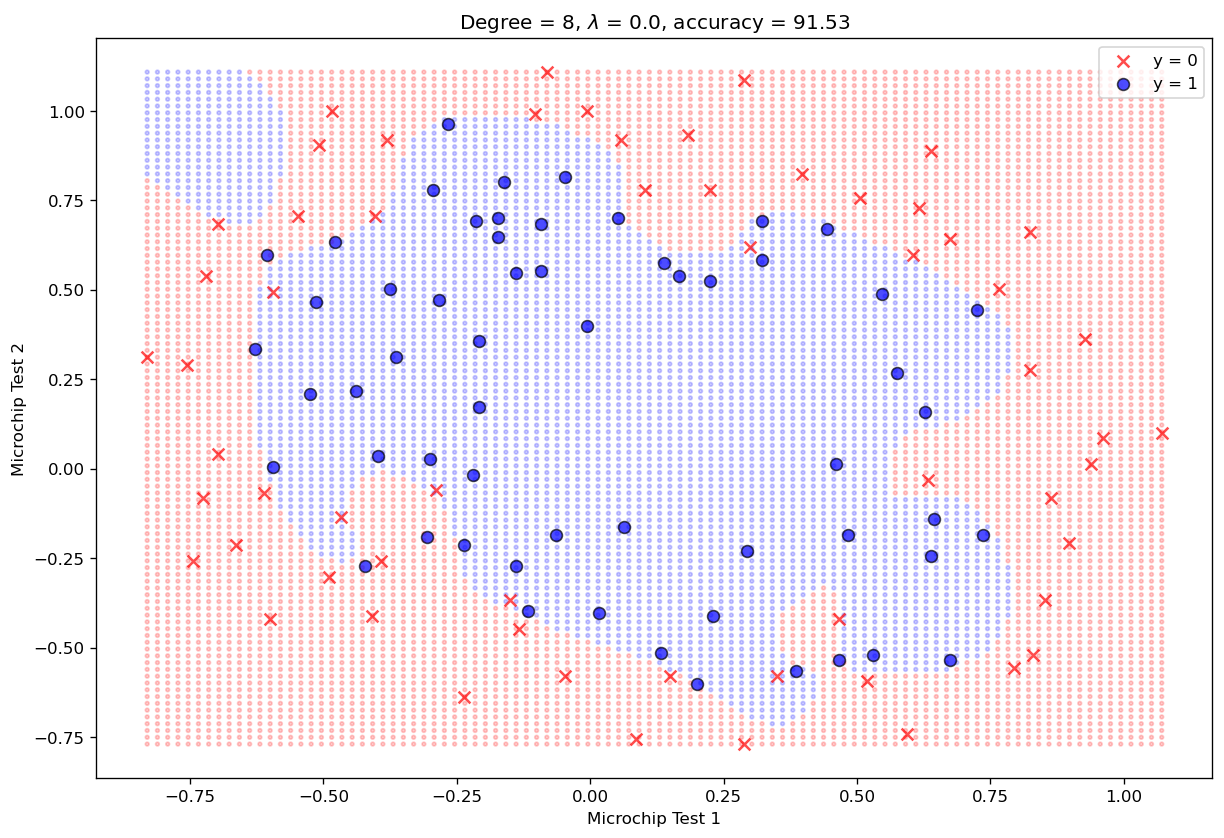

In [35]:
title = "Degree = {}, $\lambda$ = {}, accuracy = {:.2f}".format(degree, reg, acc)
plot_decision_boundary(theta_opt2, X_poly, y2.ravel(), 
                       xlabel='Microchip Test 1', ylabel='Microchip Test 2', 
                       degree=degree, title=title)

Now by trying different value for `degree` and `reg` (regularization strength), find an accurate and smooth decision boundary for the given data.

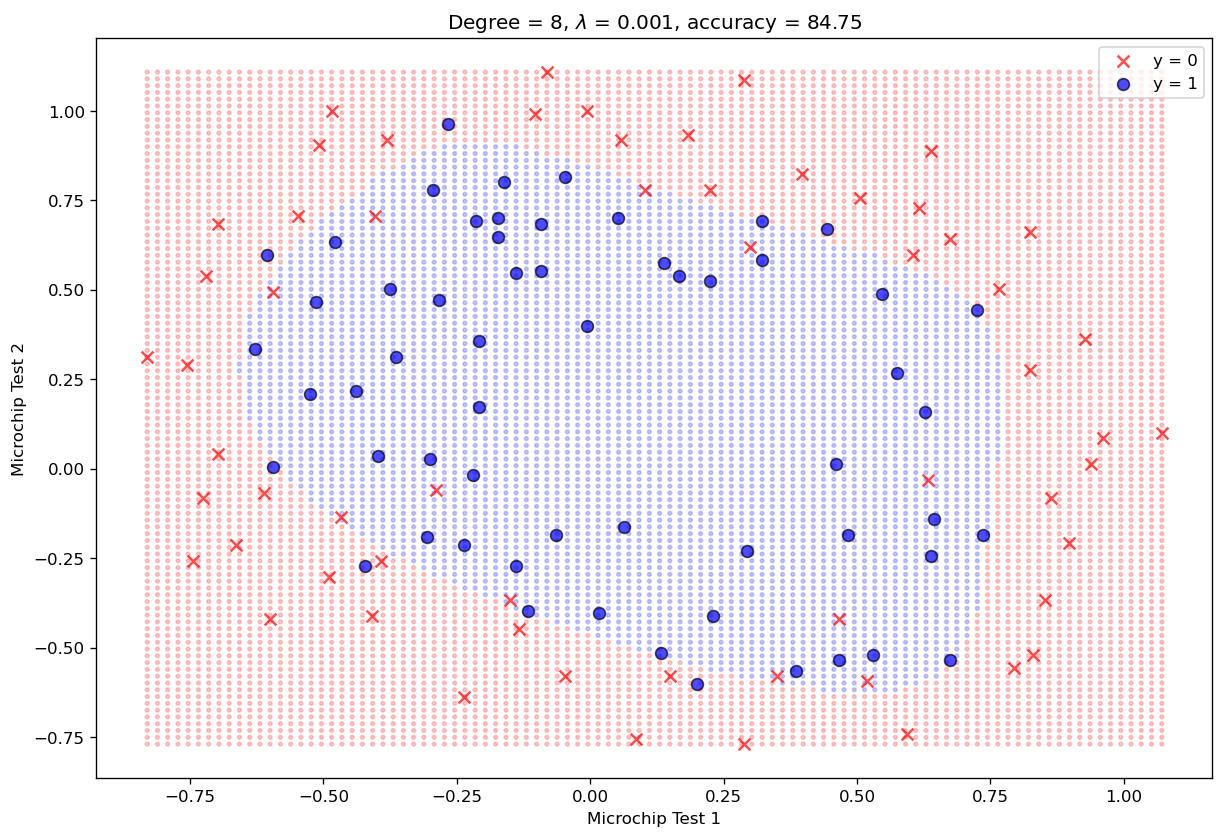

In [36]:
# change the value of these two hyper-parameters
degree = 8
reg = 0.001 # 0.001 to 100.0

# create polynomial features
X_poly = map_features(X2[:, 1], X2[:, 2], degree=degree)

# initialize theta to 0 so we will be using theta_initial_xpoly

# optimize cost function to find the optimal parameters
result = minimize(
    regularized_logistic_regression_cost, 
    x0=theta_initial_xpoly, 
    args=(X_poly, y2.ravel(), reg), 
    method='bfgs', 
    jac=regularized_grads)

# compute accuracy
theta_opt = result.x
predictions = predict(theta_opt, X_poly)
acc = accuracy(predictions, y2)

# plot decision boundary
title = "Degree = {}, $\lambda$ = {}, accuracy = {:.2f}".format(degree, reg, acc)
plot_decision_boundary(theta_opt, X_poly, y2.ravel(), 
                       xlabel='Microchip Test 1', ylabel='Microchip Test 2',
                       degree=degree, title=title)

#### Accuracy on Training Set

In [37]:
#initial_theta = np.ones(shape=(X.shape[1]))
lambda_reg = 1

result = minimize(
    regularized_logistic_regression_cost, 
    x0=theta_initial_xpoly, 
    args=(X_poly, y2.ravel(), lambda_reg), 
    method='bfgs', 
    jac=regularized_grads)

In [38]:
initial_theta = np.zeros(shape=(X_poly.shape[1]))

In [39]:
import scipy.optimize as opt
initial_theta = np.ones(shape=(X_poly.shape[1]))
def optimize_theta_reg(X, y, initial_theta, lambda_reg):
    opt_results = opt.minimize(regularized_logistic_regression_cost, initial_theta, 
                               args=(X, y, lambda_reg), method='CG', 
                               jac=regularized_grads , options={'maxiter':400})
    return opt_results['x'], opt_results['fun']

In [40]:
lambda_reg = 1
theta_optimized, cost = optimize_theta_reg(X_poly, y2, initial_theta, lambda_reg)
theta_optimized

array([ 1.49,  0.73,  1.39, -2.49, -1.54, -1.53,  0.32, -0.49, -0.49,
       -0.04, -1.72, -0.03, -0.54, -0.33, -1.28, -0.08, -0.09,  0.2 ,
       -0.08, -0.24, -0.37, -1.13,  0.25, -0.03,  0.29, -0.07, -0.01,
       -0.97, -0.21,  0.15,  0.31,  0.22,  0.3 ,  0.14, -0.02, -0.47,
       -0.77,  0.35,  0.2 ,  0.39,  0.24,  0.38,  0.14,  0.14, -0.79])

In [41]:
y_pred_prob = predict(theta_optimized,X_poly)
f'Train accuracy: {np.mean(y_pred_prob == y2) * 100}'

'Train accuracy: 83.05084745762711'

## Using Scikit-learn library

Although we implemented these algorithms from scratch, it's worth noting that we could also use a high-level python library like scikit-learn to solve this problem.

In [42]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='newton-cg', max_iter=400)
log_reg.fit(X_poly[:,1:], y2)

LogisticRegression(max_iter=400, solver='newton-cg')

In [43]:
log_reg.intercept_, log_reg.coef_

(array([1.26]),
 array([[ 0.64,  1.18, -1.95, -0.91, -1.38,  0.2 , -0.37, -0.37, -0.07,
         -1.36, -0.05, -0.62, -0.28, -1.07, -0.16, -0.2 , -0.04, -0.28,
         -0.31, -0.31, -0.95,  0.03, -0.29,  0.02, -0.32, -0.15, -0.76,
         -0.28, -0.09, -0.04, -0.11, -0.03, -0.17, -0.21, -0.34, -0.68,
          0.04, -0.15,  0.01, -0.13,  0.02, -0.19, -0.1 , -0.56]]))

In [44]:
log_reg.score(X_poly[:,1:], y2)

0.8305084745762712

In [45]:
C = 1e10 #inverse of lambda
model = linear_model.LogisticRegression(penalty='l2', C=C, fit_intercept=False)
model.fit(X_poly, y2.ravel());

/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


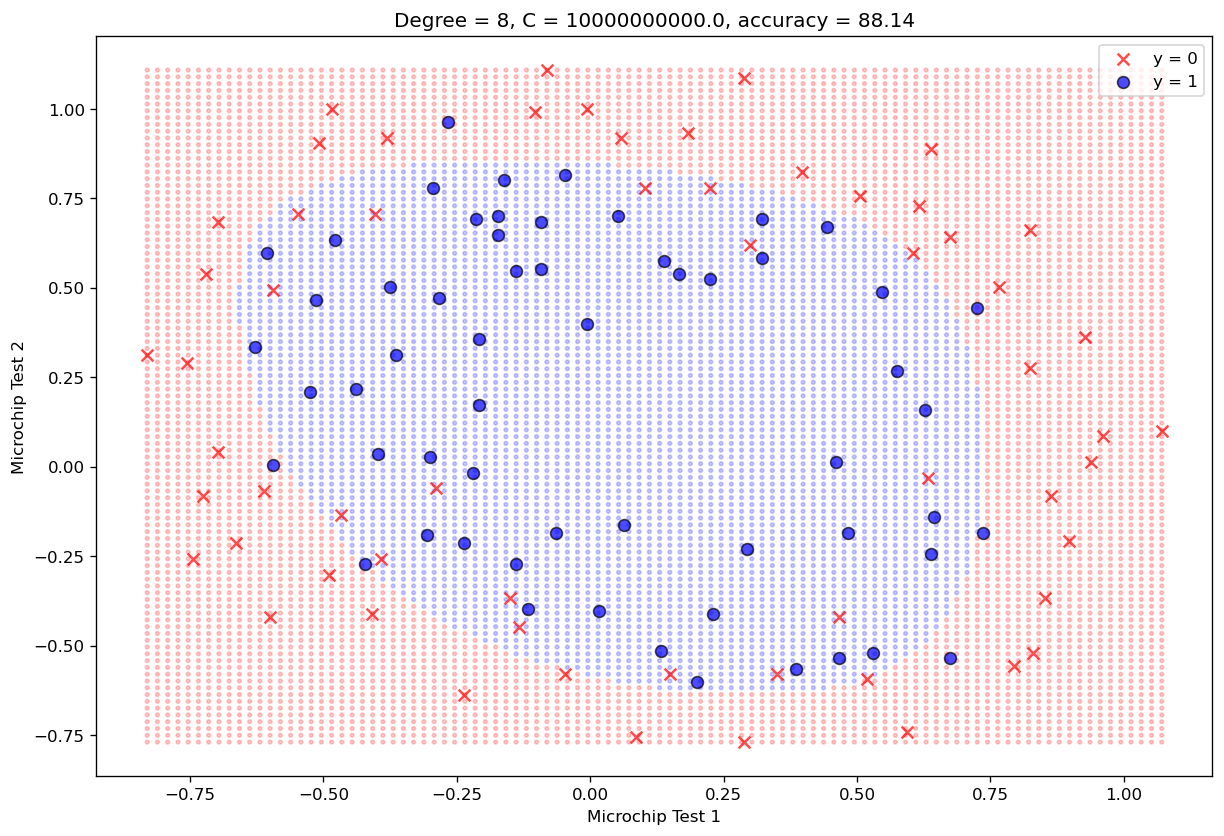

In [46]:
acc = model.score(X_poly, y2) * 100
theta_opt = np.array(model.coef_)

title = "Degree = {}, C = {}, accuracy = {:.2f}".format(degree, C, acc)
plot_decision_boundary(theta_optimized, X_poly, y2.ravel(), 
                       xlabel='Microchip Test 1', ylabel='Microchip Test 2',
                       degree=degree, title=title)